Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from sklearn.svm import SVC

Data Preparation

In [58]:
data = pd.read_csv('card_transdata.csv')

# Define features (X) and target (y)
X = data.drop('fraud', axis=1)
y = data['fraud']


# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

0.087403
0.04


Model Builder function

In [ ]:
def build_model(hidden_layers=1, units=32, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_shape=(X_train.shape[1],)))
    for _ in range(hidden_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

Neural Net hyperparameter optimizer

In [ ]:
def tune_hyperparameters():
    hidden_layer_options = [1, 2, 3]
    unit_options = [1, 16, 32, 64]

    results = []

    for hl in hidden_layer_options:
        for units in unit_options:
            print(f"Training model with hl={hl}, units={units}")
            # Track start time
            start_time = time.time()
            
            # Build and train the model
            model = build_model(hidden_layers=hl, units=units)
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                                epochs=10, batch_size=32, verbose=0)
            
            # Measure validation accuracy and training time
            val_accuracy = model.evaluate(X_val, y_val, verbose=0)[1]
            training_time = time.time() - start_time
            
            print(f"Model with hl={hl}, units={units} took {training_time:.2f} seconds.")
            results.append((hl, units, val_accuracy, training_time))
    
    return results

Show Results

In [ ]:
# Tune hyperparameters
results = tune_hyperparameters()

In [ ]:
# Unpack results
hidden_layers, units, accuracies, runtimes = zip(*results)

# Compute error rates
errors = [1 - acc for acc in accuracies]

# Plot the error rate as a function of hidden layers and units
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Error Rate Plot
sc1 = ax[0].scatter(hidden_layers, units, c=errors, cmap='viridis', s=100)
plt.colorbar(sc1, ax=ax[0], label="Error Rate")
ax[0].set_xlabel("Hidden Layers")
ax[0].set_ylabel("Units")
ax[0].set_title("Error Rate as a Function of Parameters")
# Annotate points with error rate
for i, (hl, u, e) in enumerate(zip(hidden_layers, units, errors)):
    ax[0].text(hl, u+0.5, f"{e:.5f}", fontsize=9, ha='center', va='bottom', color='red')

# Runtime Plot
sc2 = ax[1].scatter(hidden_layers, units, c=runtimes, cmap='plasma', s=100)
plt.colorbar(sc2, ax=ax[1], label="Runtime (seconds)")
ax[1].set_xlabel("Hidden Layers")
ax[1].set_ylabel("Units")
ax[1].set_title("Runtime as a Function of Parameters")
# Annotate points with runtime
for i, (hl, u, rt) in enumerate(zip(hidden_layers, units, runtimes)):
    ax[1].text(hl, u+0.5, f"{rt:.5f}s", fontsize=9, ha='center', va='bottom', color='red')

# Show plots
plt.tight_layout()
plt.show()

# Find the best parameters
best_params = results[np.argmax(accuracies)]
print("Best Parameters:", best_params)

In [34]:
# Optimize Logistic Regression Hyperparameters
def optimize_logistic_regression(X_train, y_train, X_val, y_val, C_values):
    best_acc = 0
    best_C = None
    accuracies = []

    for C in C_values:
        model = LogisticRegression(C=C, max_iter=1000, random_state=42)
        model.fit(X_train, y_train)
        acc = accuracy_score(y_val, model.predict(X_val))
        accuracies.append((C, acc))
        
        if acc > best_acc:
            best_acc = acc
            best_C = C

    return best_C, best_acc, accuracies

# Optimize KNN Hyperparameters
def optimize_knn(X_train, y_train, X_val, y_val, k_values):
    best_acc = 0
    best_k = None
    accuracies = []

    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        acc = accuracy_score(y_val, model.predict(X_val))
        accuracies.append((k, acc))  # Append a tuple (k, accuracy)
        
        if acc > best_acc:
            best_acc = acc
            best_k = k

    return best_k, best_acc, accuracies


def optimize_random_forest(X_train, y_train, X_val, y_val, n_estimators_values):
    best_n_estimators = None
    best_accuracy = 0
    accuracies = []
    
    for n in n_estimators_values:
        model = RandomForestClassifier(n_estimators=n, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        accuracies.append(acc)
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_n_estimators = n
            
    return best_n_estimators, best_accuracy, accuracies

Choosing hyperparameters for each model

In [35]:
# Define hyperparameter grids
C_values = [0.01, 0.1, 1, 10, 100]
neighbor_values = [1, 3, 5, 10, 20]
n_estimators_values = [10, 50, 100, 200]

# Optimize models
best_C, best_lr_acc, lr_accuracies = optimize_logistic_regression(X_train, y_train, X_val, y_val, C_values)
best_k, best_knn_acc, knn_accuracies = optimize_knn(X_train, y_train, X_val, y_val, neighbor_values)
best_n_estimators, best_rf_acc, rf_accuracies = optimize_random_forest(X_train, y_train, X_val, y_val, n_estimators_values)

LR plot

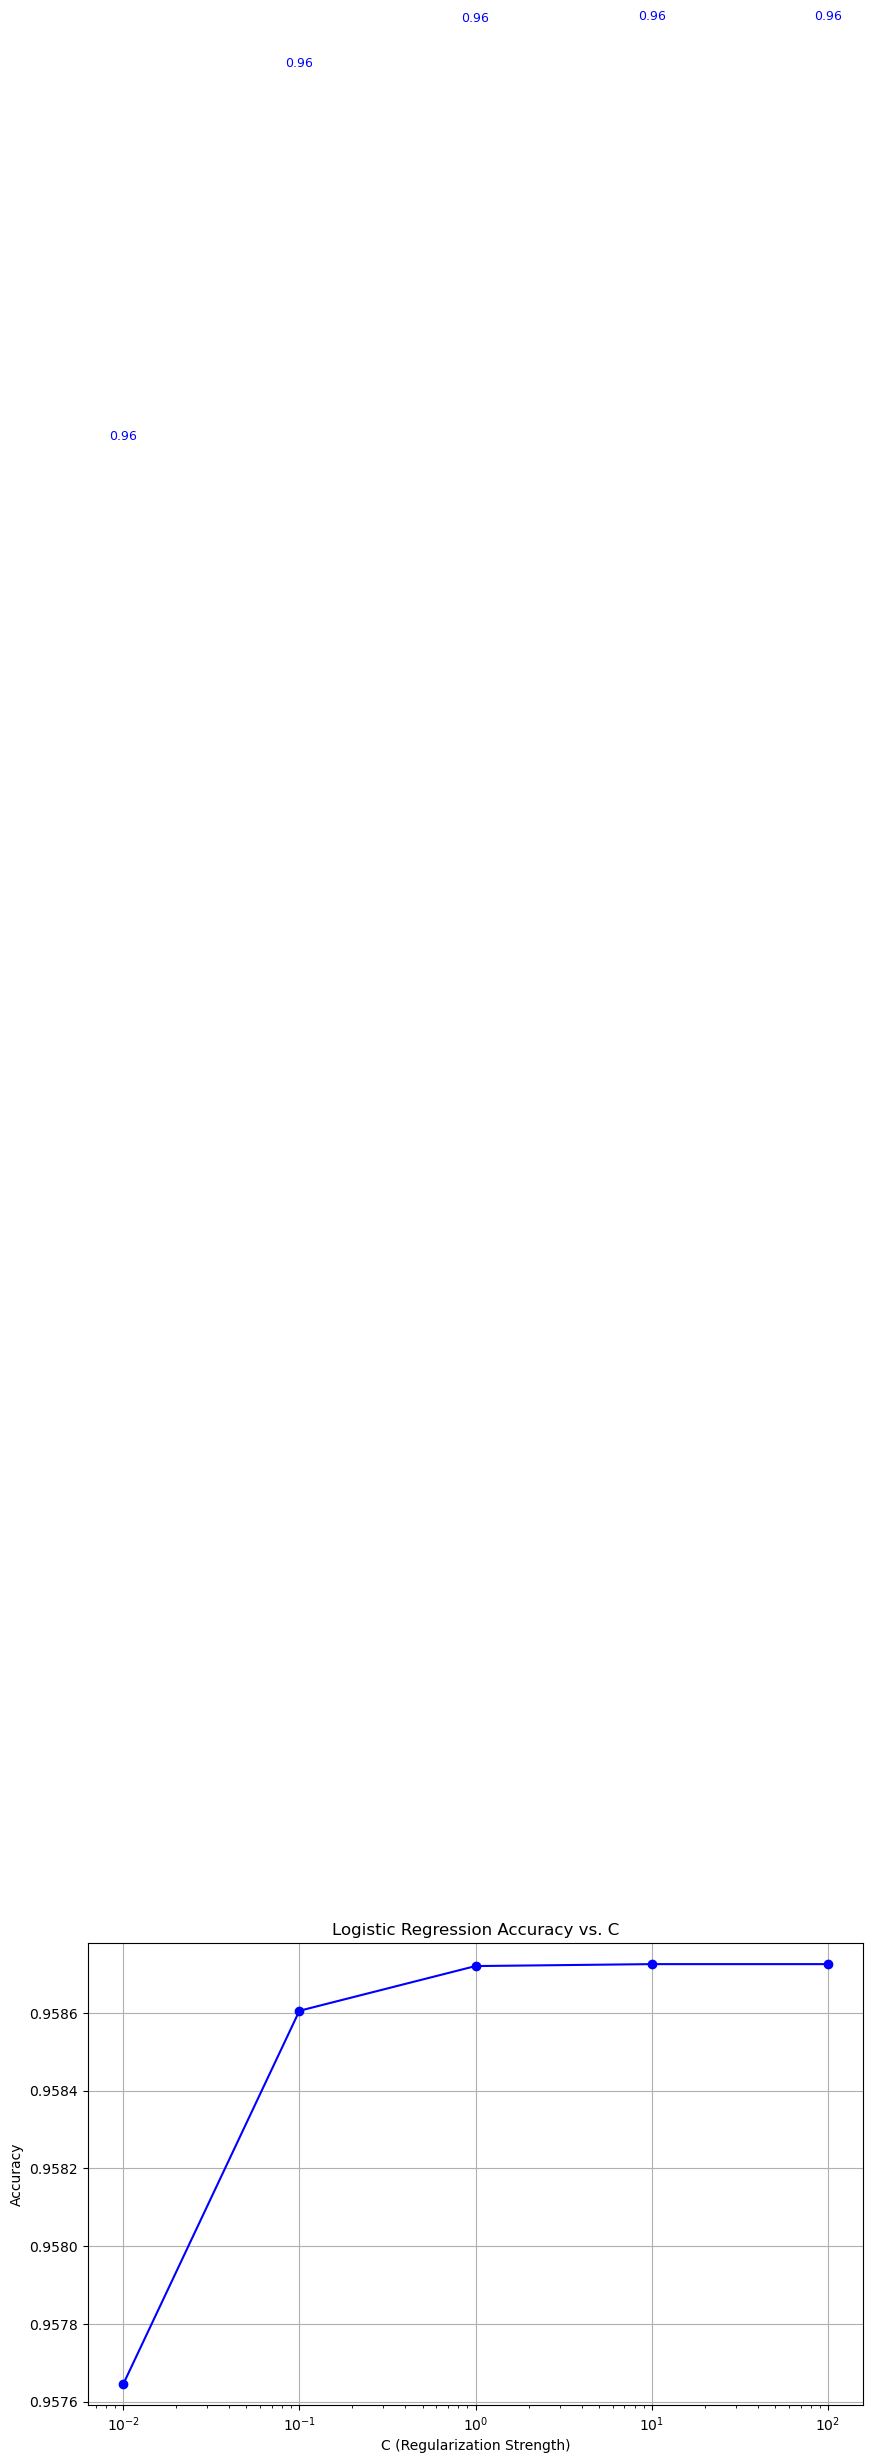

In [36]:
_, _, lr_accuracies = optimize_logistic_regression(X_train, y_train, X_val, y_val, C_values)

# Separate C and accuracy values for plotting
lr_C_values = [entry[0] for entry in lr_accuracies]
lr_accuracy_values = [entry[1] for entry in lr_accuracies]

# Plot Logistic Regression accuracies
plt.figure(figsize=(10, 6))
plt.plot(lr_C_values, lr_accuracy_values, marker='o', label='Logistic Regression', color='blue')

# Add annotations to the plot
for C, acc in zip(lr_C_values, lr_accuracy_values):
    plt.text(C, acc + 0.005, f"{acc:.2f}", ha='center', fontsize=9, color='blue')

# Set a logarithmic scale for the x-axis
plt.xscale('log')
plt.xlabel("C (Regularization Strength)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy vs. C")
plt.grid()
plt.show()

KNN Plot

[0.998775, 0.998815, 0.99874, 0.998555, 0.998465]


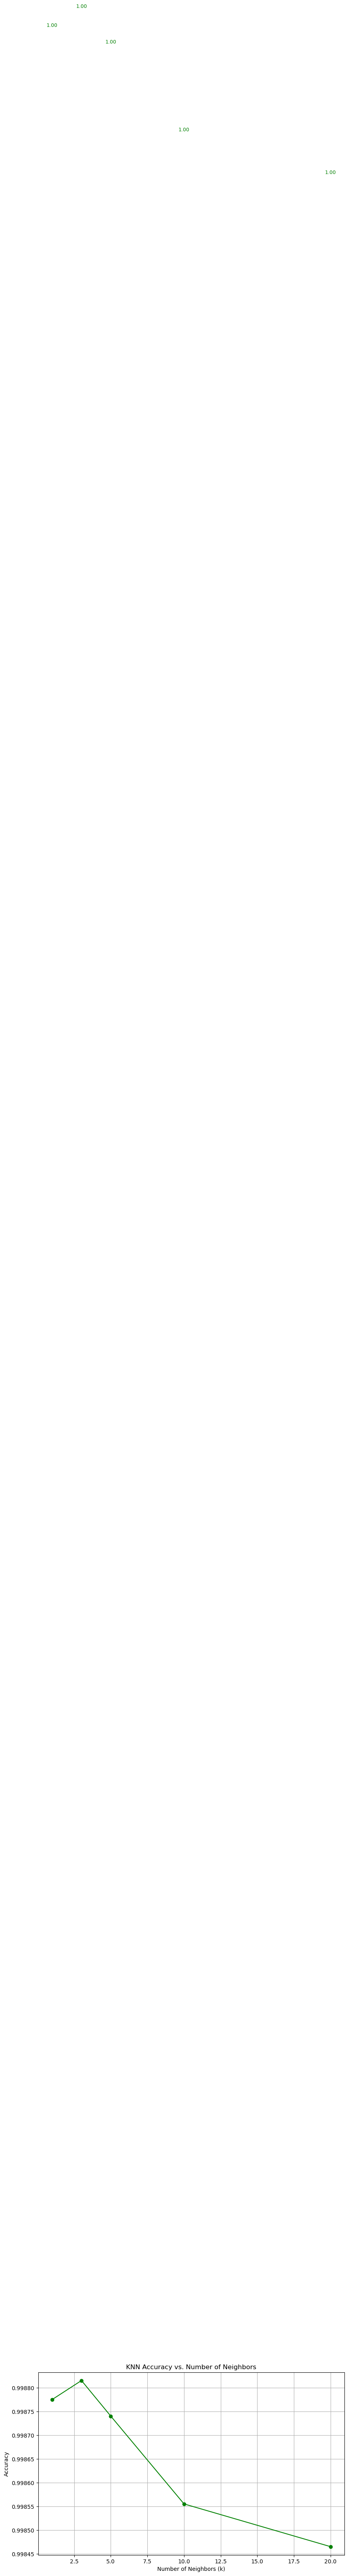

In [37]:
# Assuming optimize_knn returns a tuple with accuracies and runtimes
_, _, knn_results = optimize_knn(X_train, y_train, X_val, y_val, neighbor_values)

# Extract accuracies (if knn_results is a list of tuples)
knn_accuracies = [i[1] for i in knn_results]
print(knn_accuracies)

# Plot the KNN accuracies
plt.figure(figsize=(10, 6))
plt.plot(neighbor_values, knn_accuracies, marker='o', label='KNN', color='green')

# Ensure knn_accuracies contains only accuracy values
for k, acc in zip(neighbor_values, knn_accuracies):
    plt.text(k, acc + 0.005, f"{acc:.2f}", ha='center', fontsize=9, color='green')

plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs. Number of Neighbors")
plt.grid()
plt.show()

Random Forest Plot

In [50]:
# Optimize Random Forest
best_n_estimators, best_rf_acc, rf_accuracies = optimize_random_forest(
    X_train, y_train, X_val, y_val, n_estimators_values
)

# Print accuracy for each number of estimators
print("Random Forest Accuracies:")
for n, acc in zip(n_estimators_values, rf_accuracies):
    print(f"Number of Estimators: {n}, Accuracy: {acc:.6f}")

# Print the best number of estimators and its accuracy
print("\nBest Random Forest Configuration:")
print(f"Number of Estimators: {best_n_estimators}, Accuracy: {best_rf_acc:.6f}")

Random Forest Accuracies:
Number of Estimators: 10, Accuracy: 0.999985
Number of Estimators: 50, Accuracy: 0.999990
Number of Estimators: 100, Accuracy: 0.999990
Number of Estimators: 200, Accuracy: 0.999990

Best Random Forest Configuration:
Number of Estimators: 50, Accuracy: 0.999990


Print Results

In [42]:
print(f"Optimized Logistic Regression: C={best_C}, Accuracy={best_lr_acc:.5f}")
print(f"Optimized K-Nearest Neighbors: k={best_k}, Accuracy={best_knn_acc:.5f}")
print(f"Optimized Random Forest: n_estimators={best_n_estimators}, Accuracy={best_rf_acc:.5f}")

Optimized Logistic Regression: C=10, Accuracy=0.95873
Optimized K-Nearest Neighbors: k=3, Accuracy=0.99882
Optimized Random Forest: n_estimators=50, Accuracy=0.99999


Time each model

In [43]:
# Measure fitting time for Logistic Regression
start_time = time.time()
lr_model = LogisticRegression(max_iter=1000, random_state=42, C=best_C)
lr_model.fit(X_train, y_train)
lr_runtime = time.time() - start_time

# Measure fitting time for K-Nearest Neighbors
start_time = time.time()
knn_model_opt = KNeighborsClassifier(n_neighbors=best_k)
knn_model_opt.fit(X_train, y_train)
knn_runtime = time.time() - start_time

# Measure fitting time for Random Forest
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
rf_model.fit(X_train, y_train)
rf_runtime = time.time() - start_time

Graph model vs runtime

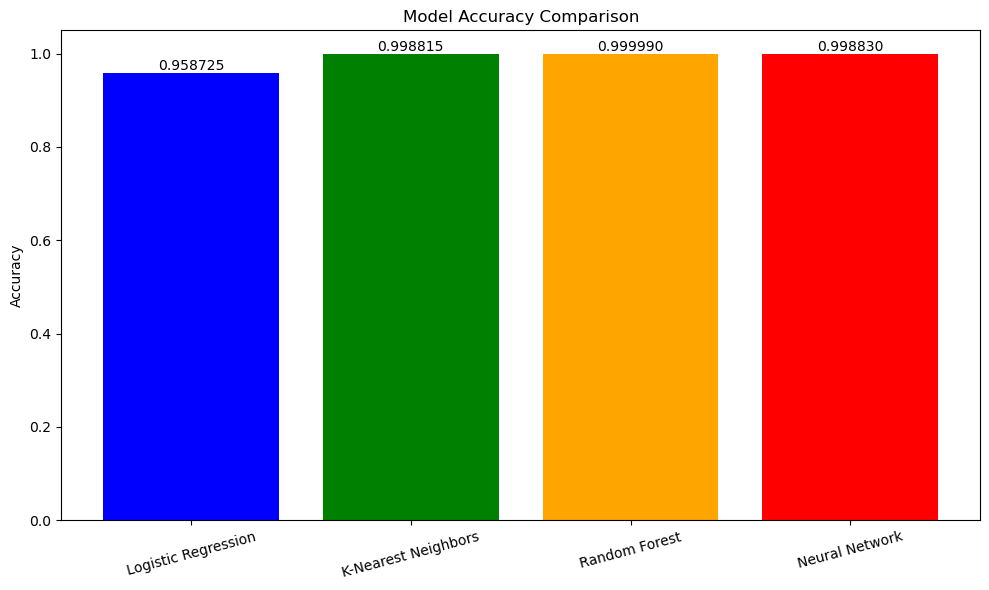

In [49]:
# Model names and their accuracies
model_names = ["Logistic Regression", "K-Nearest Neighbors", "Random Forest", "Neural Network"]
accuracies = [best_lr_acc, best_knn_acc, best_rf_acc, best_params[2]]  # Add your neural network accuracy here (best_nn_acc)

plt.figure(figsize=(10, 6))

# Create a bar plot
bars = plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'red'])

# Annotate bars with their accuracy values
for bar, acc in zip(bars, accuracies):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        bar.get_height(),           # Y-coordinate (slightly above the bar)
        f"{acc:.6f}",                      # Annotated text (formatted accuracy)
        ha='center',                       # Center the text horizontally
        va='bottom',                       # Align text to the bottom
        fontsize=10,                       # Font size for readability
        color='black'                      # Text color
    )

# Set labels and title
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=15)  # Slightly rotate the labels for better visibility
plt.tight_layout()

# Show the plot
plt.show()


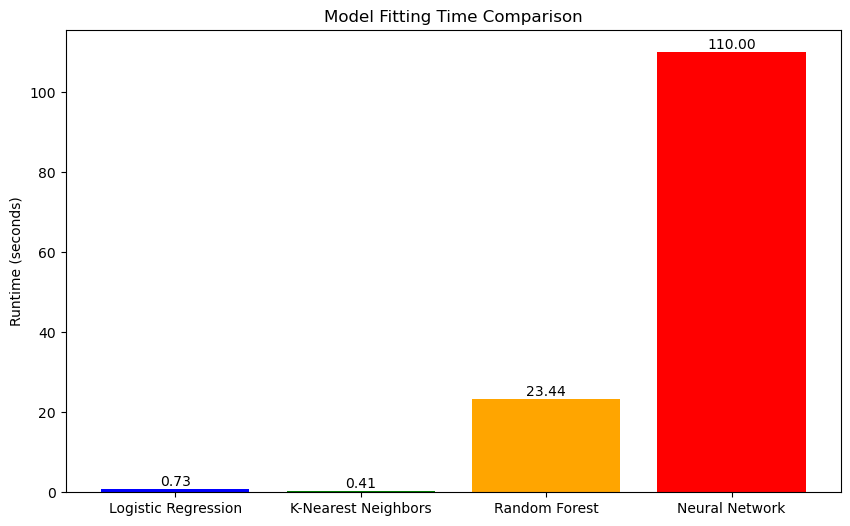

In [54]:
model_names = ["Logistic Regression", "K-Nearest Neighbors", "Random Forest", "Neural Network"]
runtimes = [lr_runtime, knn_runtime, rf_runtime, best_params[3]]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, runtimes, color=['blue', 'green', 'orange', 'red'])

# Add the runtime values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

plt.ylabel("Runtime (seconds)")
plt.title("Model Fitting Time Comparison")
plt.show()